In [24]:
import kagglehub

import matplotlib.pyplot as plt
import pandas as pd
import os
import shutil
from pathlib import Path

import random
from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam


### 1. Load Dataset from Kaggle

In [ ]:
# Download latest version of dataset from kaggle url(https://www.kaggle.com/datasets/derekkunowilliams/mushrooms)
path = kagglehub.dataset_download("derekkunowilliams/mushrooms")
print("Path to dataset files:", path)

/Users/mikolajkahl/kahlus2001/mobile-net-mushroom-classification/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 74.5M/74.5M [00:03<00:00, 25.7MB/s]

Extracting files...


Path to dataset files: /Users/mikolajkahl/.cache/kagglehub/datasets/derekkunowilliams/mushrooms/versions/1


In [ ]:
source_root = Path(os.path.join(path, "mushroom_dataset"))
dest_root = Path("mushroom_dataset_4class")
dest_root.mkdir(exist_ok=True)

# Define the top-level labels
labels = ["edible", "deadly", "poisonous", "conditionally_edible"]

# Create destination folders and flatten species into category
for label in labels:
    src_label_path = source_root / label
    dst_label_path = dest_root / label
    dst_label_path.mkdir(parents=True, exist_ok=True)

    for species_dir in src_label_path.iterdir():
        if species_dir.is_dir():
            for img_file in species_dir.glob("*.*"):  # Match .png, .jpg, etc.
                # Generate a unique filename to avoid overwriting
                dest_file = dst_label_path / f"{species_dir.name}_{img_file.name}"
                shutil.copy(img_file, dest_file)

print("Dataset flattened to 4-class format at:", dest_root.resolve())


✅ Dataset flattened to 4-class format at: /Users/mikolajkahl/kahlus2001/mobile-net-mushroom-classification/mushroom_dataset_4class


### 2. Basic Exploratory Data Analysis

Matplotlib is building the font cache; this may take a moment.


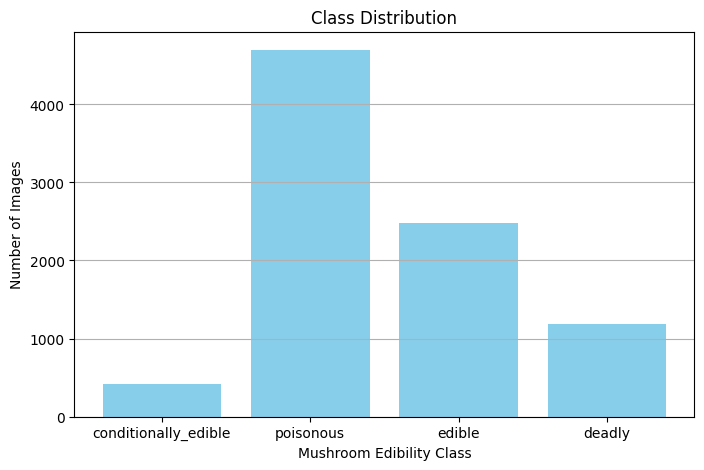

In [ ]:
# Root path of the dataset
root_dir = "mushroom_dataset_4class"

# Count number of images per class
class_counts = {}
for class_name in os.listdir(root_dir):
    class_path = os.path.join(root_dir, class_name)
    if os.path.isdir(class_path):
        class_counts[class_name] = len([
            f for f in os.listdir(class_path) 
            if os.path.isfile(os.path.join(class_path, f))
        ])

# Plot
plt.figure(figsize=(8, 5))
plt.bar(class_counts.keys(), class_counts.values(), color="skyblue")
plt.title("Class Distribution")
plt.ylabel("Number of Images")
plt.xlabel("Mushroom Edibility Class")
plt.grid(True, axis='y')
plt.show()


In [19]:
df = pd.DataFrame(list(class_counts.items()), columns=["Class", "Count"])
print(df.sort_values("Count", ascending=False))

                  Class  Count
1             poisonous   4696
2                edible   2475
3                deadly   1190
0  conditionally_edible    420


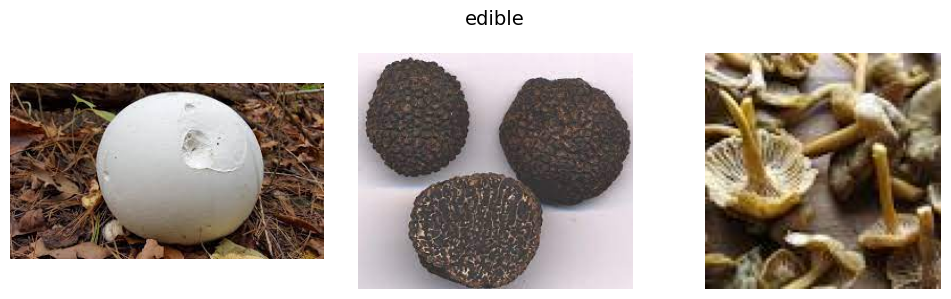

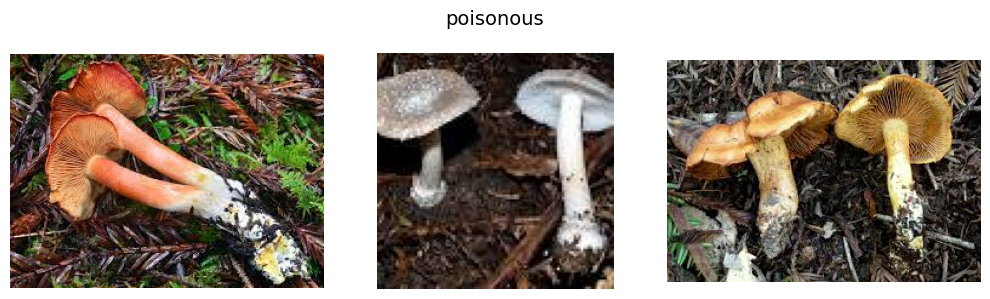

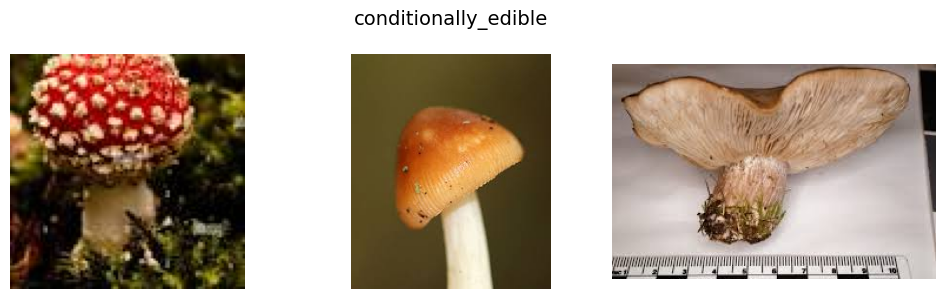

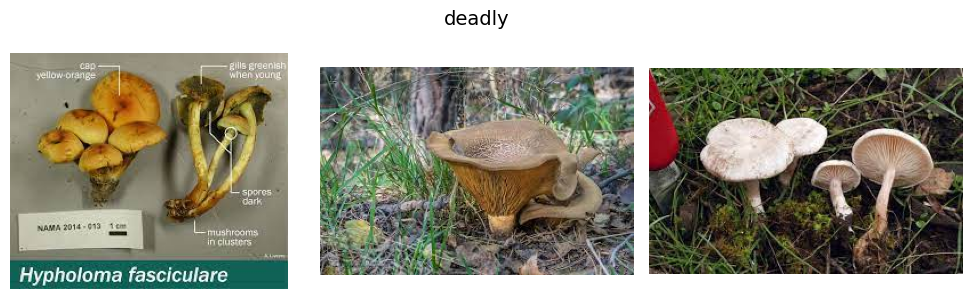

In [ ]:
# Root directory with your 4 classes
root_dir = "mushroom_dataset_4class"
class_names = ["edible", "poisonous", "conditionally_edible", "deadly"]

def show_3_random_images_per_class():
    for class_name in class_names:
        class_path = os.path.join(root_dir, class_name)
        all_images = os.listdir(class_path)
        sample_imgs = random.sample(all_images, min(3, len(all_images)))

        plt.figure(figsize=(10, 3))
        for i, img_name in enumerate(sample_imgs):
            img_path = os.path.join(class_path, img_name)
            img = Image.open(img_path)

            plt.subplot(1, 3, i + 1)
            plt.imshow(img)
            plt.axis('off')

        plt.suptitle(f"{class_name}", fontsize=14)
        plt.tight_layout()
        plt.show()

show_3_random_images_per_class()


### 3. Train-Test split

In [10]:
# Load training dataset (80%)
train_ds = tf.keras.utils.image_dataset_from_directory(
    "mushroom_dataset_4class",
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

# Load validation dataset (20%)
val_ds = tf.keras.utils.image_dataset_from_directory(
    "mushroom_dataset_4class",
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

# Class names
class_names = train_ds.class_names
print("Classes:", class_names)

Found 8781 files belonging to 4 classes.
Using 7025 files for training.
Found 8781 files belonging to 4 classes.
Using 1756 files for validation.
Classes: ['conditionally_edible', 'deadly', 'edible', 'poisonous']


In [ ]:
# performance optimization for loading data
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)


In [18]:
for images, labels in train_ds.take(1):
    print(f"Image batch shape: {images.shape}")
    print(f"Label batch shape: {labels.shape}")
    print(f"Image dtype: {images.dtype}")
    print(f"Label dtype: {labels.dtype}")


Image batch shape: (32, 224, 224, 3)
Label batch shape: (32,)
Image dtype: <dtype: 'float32'>
Label dtype: <dtype: 'int32'>


2025-04-09 22:27:15.541932: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### 4. Load MobileNetV2 Model

In [20]:
# Load base model
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze all layers

# Add custom classifier head
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(4, activation='softmax')  # 4 classes
])


In [21]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


### 5. Benchmark pre-fine tuning

In [23]:
loss, acc = model.evaluate(val_ds)
print(f"\nLoss: {loss:.4f}")
print(f"Baseline accuracy (non-finetuned): {acc:.4f}")


55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 0.0916 - loss: 2.0121

Loss: 2.0071
Baseline accuracy (non-finetuned): 0.0917


### 6. Fine-tuning

In [25]:
# Unfreeze the last few layers of base model
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Add classification head
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(4, activation='softmax')  # 4-class
])

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Smaller LR for fine-tuning
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Epoch 1/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 58s 254ms/step - accuracy: 0.4420 - loss: 1.2994 - val_accuracy: 0.2312 - val_loss: 1.5486
Epoch 2/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 56s 256ms/step - accuracy: 0.5227 - loss: 1.1199 - val_accuracy: 0.3719 - val_loss: 1.3376
Epoch 3/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 55s 249ms/step - accuracy: 0.5573 - loss: 1.0582 - val_accuracy: 0.4755 - val_loss: 1.2256
Epoch 4/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 54s 245ms/step - accuracy: 0.5699 - loss: 1.0236 - val_accuracy: 0.5137 - val_loss: 1.1556
Epoch 5/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 55s 251ms/step - accuracy: 0.5798 - loss: 0.9961 - val_accuracy: 0.5330 - val_loss: 1.1244
Epoch 6/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 55s 252ms/step - accuracy: 0.5931 - loss: 0.9589 - val_accuracy: 0.5404 - val_loss: 1.1023
Epoch 7/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 56s 253ms/step - accuracy: 0.6182 - loss: 0.9313 - val_accuracy: 0.5456 - val_loss: 1.0938
Epoch 8/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 56s 253ms/step - accuracy: 0.6118 - loss: 0

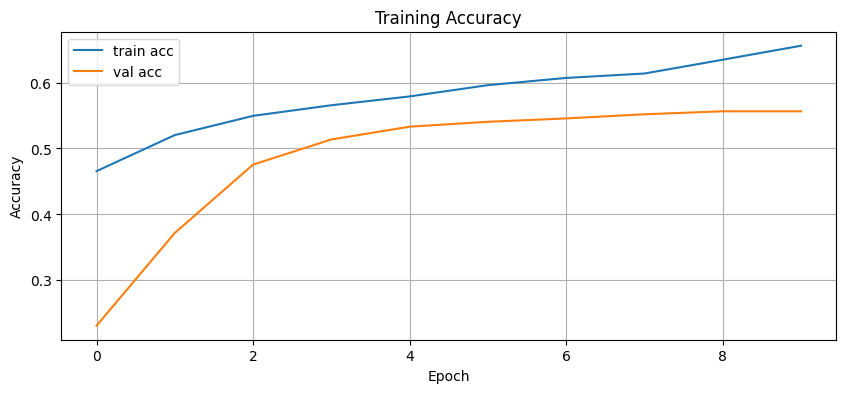

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

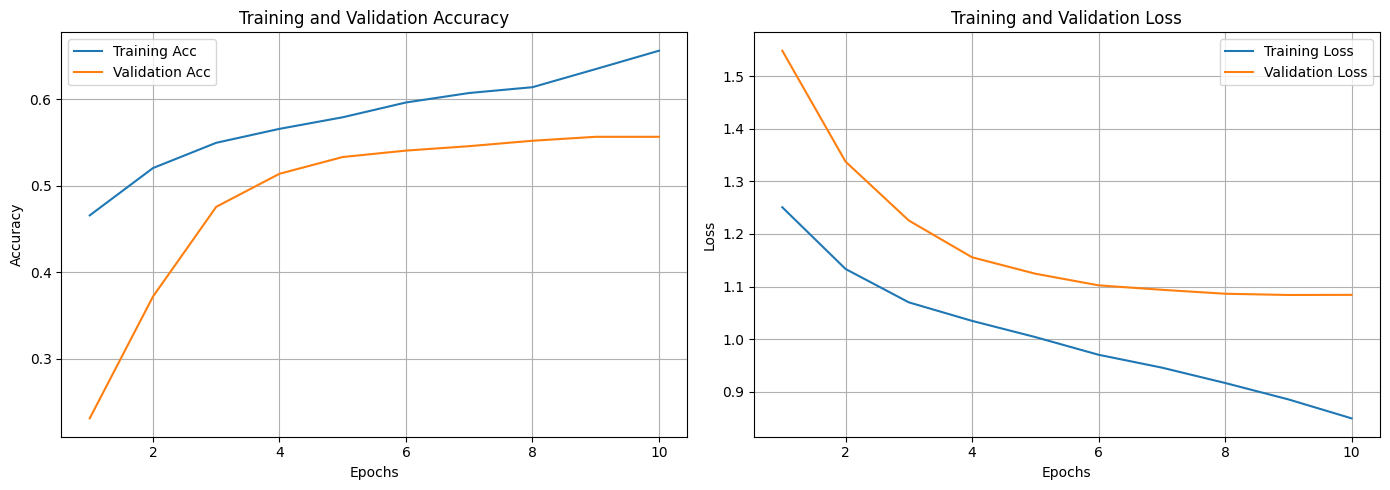

In [32]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Acc')
    plt.plot(epochs, val_acc, label='Validation Acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [29]:
model.save("mobilenet_finetuned_mushrooms_base_1.keras")

### 7. Evaluation

In [33]:
loss, acc = model.evaluate(val_ds)
print(f"\nLoss: {loss:.4f}")
print(f"accuracy (finetuned): {acc:.4f}")

55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 0.5675 - loss: 1.0735

Loss: 1.0842
accuracy (finetuned): 0.5564
